In [1]:
# Import some libraries we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import scipy.sparse as sps
from scipy.sparse import csr_matrix

In [2]:
def read_review_data(file_name):
    review_data = pd.read_csv(file_name)
    print "Sample Data"
    print "-----------"
    print review_data.sample(5)
    return review_data

In [3]:
business_data = pd.read_csv('business.csv')
business_data.head(1)

,hours.Wednesday,attributes.RestaurantsDelivery,attributes.Open24Hours,attributes.DogsAllowed,attributes.CoatCheck,postal_code,attributes.Smoking,hours.Thursday,attributes.DietaryRestrictions,city,...,attributes.RestaurantsAttire,hours.Sunday,attributes.GoodForMeal,attributes.GoodForDancing,attributes.AcceptsInsurance,attributes.RestaurantsReservations,attributes,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,11:0-21:0,False,NaN,NaN,NaN,T2E 6L6,NaN,11:0-21:0,NaN,Calgary,...,casual,NaN,NaN,NaN,NaN,True,"{'BusinessParking': ""{'garage': False, 'street...",True,False,False


In [4]:
business_data.set_index('business_id', inplace = True)

In [5]:
def get_restaurant_data(review_data, business_data):
    review_data['city'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'city'], axis=1)
    review_data['cat'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'categories'], axis=1)
    restaurant_reviews = review_data[review_data['cat'].str.contains("Restaurants",na=False)]
    return restaurant_reviews

In [6]:
def get_city_restaurant_data(city, restaurant_reviews):
    city_rest_data = restaurant_reviews.loc[review_data['city'] == city]
    return city_rest_data

In [7]:
review_data = read_review_data('40core.csv')
print '-----------------------------'
print 'Filtering the Restaurant data'
print '-----------------------------'
restaurant_reviews = get_restaurant_data(review_data, business_data)
print restaurant_reviews.head(3)
print '-----------------------------'
print 'restaurant reviews top 10 cities'
print '-----------------------------'
print restaurant_reviews['city'].value_counts().head(10)
print '-----------------------------'
vegas_40 = get_city_restaurant_data('Las Vegas', restaurant_reviews)

Sample Data
-----------
                      user_id             business_id  stars
52146  7PVY7A7Top7ButcfLkTJTA  TCWMgOiV0PxQkWE1SyBIWQ      5
54844  LvLaYXjvzdrPDXC3Zv3XoA  K7lWdNUhCbcnEvI0NhGewg      2
81857  U4INQZOPSUaj8hMjLlZ3KA  iCQpiavjjPzJ5_3gPD5Ebg      4
32282  De-dImXf-TOFWWPTUWwIvw  jobP3ywRd3QNZ_GCoPG2DQ      5
41446  iH5YQPtx1qrNG4t2-DjI3Q  dKdApYVFDSNYsNOso6NYlA      3
-----------------------------
Filtering the Restaurant data
-----------------------------
                  user_id             business_id  stars       city  \
0  AuIK5tF2GjO7SftHawTLKw  I-5qHCVwT7k_KH67-YOx3A      4  Henderson   
2  AuIK5tF2GjO7SftHawTLKw  Zmfq3DVhHdtVChhSxzoUHw      4  Las Vegas   
3  AuIK5tF2GjO7SftHawTLKw  pybIuTluqRhH_BQ3CJHlLw      5  Las Vegas   

                                                 cat  
0  Desserts, Restaurants, American (Traditional),...  
2                                  Restaurants, Thai  
3                                  Thai, Restaurants  
---------------

In [8]:
vegas_40.reset_index(inplace=True)
cols = ['index', 'cat', 'city']
vegas_40.drop(cols, inplace=True, axis=1)

/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [10]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(vegas_40[['user_id', 'business_id', 'stars']], reader)

In [11]:
trainset, testset = train_test_split(data, test_size=0.25)

In [13]:
svd = SVD(biased=False)

In [20]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.01, 0.1, 0.4, 0.6], 'n_factors':[100,300,500], 'biased':[False]}

In [21]:
from surprise.model_selection import GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)

In [22]:
gs.fit(data)

In [24]:
gs.best_score

{'mae': 0.8025508385787404}

In [25]:
gs.best_params

{'mae': {'biased': False,
  'lr_all': 0.005,
  'n_epochs': 10,
  'n_factors': 100,
  'reg_all': 0.01}}

In [26]:
svd = SVD(biased=False, lr_all=0.05, n_epochs=10, n_factors=100, reg_all=0.01)

In [27]:
predictions = svd.fit(trainset).test(testset)
accuracy.mae(predictions)

MAE:  0.8300


0.8300410631362501

In [33]:
param_grid = {'n_factors':[100,150,200,250, 300,350,400,450, 500]}

In [34]:
from surprise.model_selection import GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)

In [35]:
gs.fit(data)

In [36]:
gs.cv_results

{u'mean_fit_time': array([ 2.56945809,  3.46781898,  4.40062594,  5.29327528,  6.36720761,
         7.4448057 ,  8.52768962, 12.12004399, 12.76911767]),
 u'mean_test_mae': array([0.73256896, 0.73525204, 0.73881196, 0.74249753, 0.74372603,
        0.74729488, 0.75005685, 0.7502105 , 0.75258454]),
 u'mean_test_time': array([0.33552694, 0.35509237, 0.33023222, 0.35422762, 0.33065168,
        0.35641106, 0.3347133 , 0.41052437, 0.3577923 ]),
 u'param_n_factors': [100, 150, 200, 250, 300, 350, 400, 450, 500],
 u'params': [{'n_factors': 100},
  {'n_factors': 150},
  {'n_factors': 200},
  {'n_factors': 250},
  {'n_factors': 300},
  {'n_factors': 350},
  {'n_factors': 400},
  {'n_factors': 450},
  {'n_factors': 500}],
 u'rank_test_mae': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 u'split0_test_mae': array([0.73238964, 0.73633799, 0.73859127, 0.7428926 , 0.74550296,
        0.74901756, 0.75063226, 0.75081363, 0.75664852]),
 u'split1_test_mae': array([0.73545029, 0.73802571, 0.7412542 , 0.74561371, 0.7

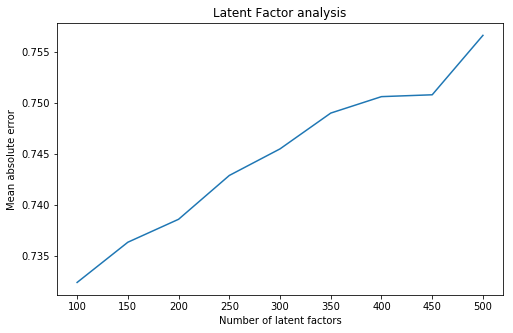

In [40]:
X=gs.cv_results['param_n_factors']
Y=gs.cv_results['split0_test_mae']
fig = plt.figure(figsize=(8,5))
plt.plot(X, Y)
plt.title('Latent Factor analysis')
plt.xlabel('Number of latent factors')
plt.ylabel('Mean absolute error')
plt.show()

In [45]:
param_grid = {'lr_all':[0.002, 0.005, 0.02, 0.05, 0.07 , 0.1,0.2, 0.3, 0.5]}
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)
gs.fit(data)
gs.cv_results

{u'mean_fit_time': array([2.72456169, 2.82444557, 2.56495404, 2.56544105, 2.55511999,
        2.555691  , 2.5524617 , 2.55912836, 2.55699436]),
 u'mean_test_mae': array([0.73313803, 0.73221374, 0.77572431, 0.77577932, 0.77580708,
        0.77611844, 1.16842583, 1.16842583, 1.16842583]),
 u'mean_test_time': array([0.39904571, 0.39122264, 0.35261464, 0.32290292, 0.34439731,
        0.31728975, 0.34309212, 0.31372865, 0.34238577]),
 u'param_lr_all': [0.002, 0.005, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.5],
 u'params': [{'lr_all': 0.002},
  {'lr_all': 0.005},
  {'lr_all': 0.02},
  {'lr_all': 0.05},
  {'lr_all': 0.07},
  {'lr_all': 0.1},
  {'lr_all': 0.2},
  {'lr_all': 0.3},
  {'lr_all': 0.5}],
 u'rank_test_mae': array([2, 1, 3, 4, 5, 6, 7, 8, 9]),
 u'split0_test_mae': array([0.72819377, 0.72639104, 0.77058244, 0.77020247, 0.76981636,
        0.77321997, 1.16585802, 1.16585802, 1.16585802]),
 u'split1_test_mae': array([0.73800863, 0.73734509, 0.7813419 , 0.78191623, 0.78119295,
        0.779642

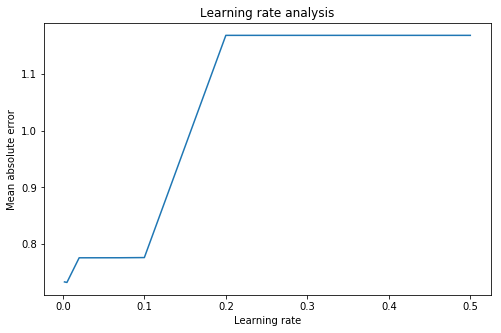

In [47]:
X=gs.cv_results['param_lr_all']
Y=gs.cv_results['mean_test_mae']
fig = plt.figure(figsize=(8,5))
plt.plot(X, Y)
plt.title('Learning rate analysis')
plt.xlabel('Learning rate')
plt.ylabel('Mean absolute error')
plt.show()

In [48]:
param_grid = {'reg_all': [0.01, 0.1, 0.4, 0.6, 1, 5, 10]}
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)
gs.fit(data)
gs.cv_results

{u'mean_fit_time': array([2.70667203, 2.55993867, 2.68170158, 2.73873369, 2.65938965,
        2.63783439, 2.61855801]),
 u'mean_test_mae': array([0.73562088, 0.72699636, 0.7298691 , 0.73350163, 0.74055928,
        0.77650028, 0.78937875]),
 u'mean_test_time': array([0.41140509, 0.34350634, 0.3914779 , 0.34342035, 0.37864836,
        0.3230439 , 0.35313535]),
 u'param_reg_all': [0.01, 0.1, 0.4, 0.6, 1, 5, 10],
 u'params': [{'reg_all': 0.01},
  {'reg_all': 0.1},
  {'reg_all': 0.4},
  {'reg_all': 0.6},
  {'reg_all': 1},
  {'reg_all': 5},
  {'reg_all': 10}],
 u'rank_test_mae': array([4, 1, 2, 3, 5, 6, 7]),
 u'split0_test_mae': array([0.73527474, 0.72754194, 0.72967191, 0.73305867, 0.7394204 ,
        0.77424026, 0.78703684]),
 u'split1_test_mae': array([0.73770034, 0.72756932, 0.73090127, 0.73478094, 0.74218522,
        0.77851705, 0.79146166]),
 u'split2_test_mae': array([0.73388756, 0.72587782, 0.72903413, 0.73266527, 0.74007223,
        0.77674352, 0.78963775]),
 u'std_fit_time': array(

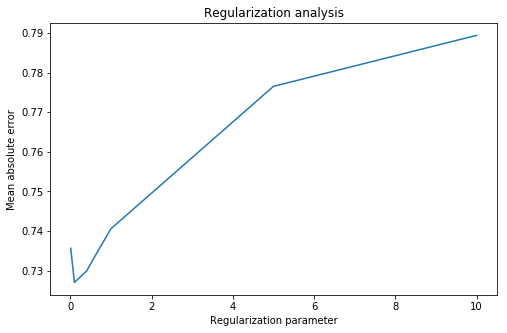

In [49]:
X=gs.cv_results['param_reg_all']
Y=gs.cv_results['mean_test_mae']
fig = plt.figure(figsize=(8,5))
plt.plot(X, Y)
plt.title('Regularization analysis')
plt.xlabel('Regularization parameter')
plt.ylabel('Mean absolute error')
plt.show()

In [50]:
svd = SVD(biased=False, lr_all=0.05, n_epochs=10, n_factors=100, reg_all=0.01)
predictions = svd.fit(trainset).test(testset)

In [51]:
print len(predictions)

17622
